# Projecting Population Growth

In [1]:
import numpy
import pandas

from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [30]:
filename = "World_population_estimates.html"
tables = pandas.read_html(
    filename,
    header=0,
    index_col=0,
    decimal='M',
)

table2 = tables[2]

table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

un = table2.un / 1e9
census = table2.census / 1e9

t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

In [3]:
def growth_func_quad(t, pop, system):
    return system.alpha * pop + system.beta * pop**2

In [6]:
def run_simulation(system, growth_func):
    results = modsim.TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(int(system.t_0), int(system.t_end)):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

In [31]:
t_0 = census.index[0]
p_0 = census[t_0]

system = modsim.System(
    t_0 = t_0,
    p_0 = p_0,
    alpha = 25 / 1000,
    beta = -1.8 / 1000,
    t_end = 2100,
)

In [32]:
results = run_simulation(system, growth_func_quad)

In [33]:
results.tail()

2096    12.462519
2097    12.494516
2098    12.525875
2099    12.556607
2100    12.586719
dtype: float64

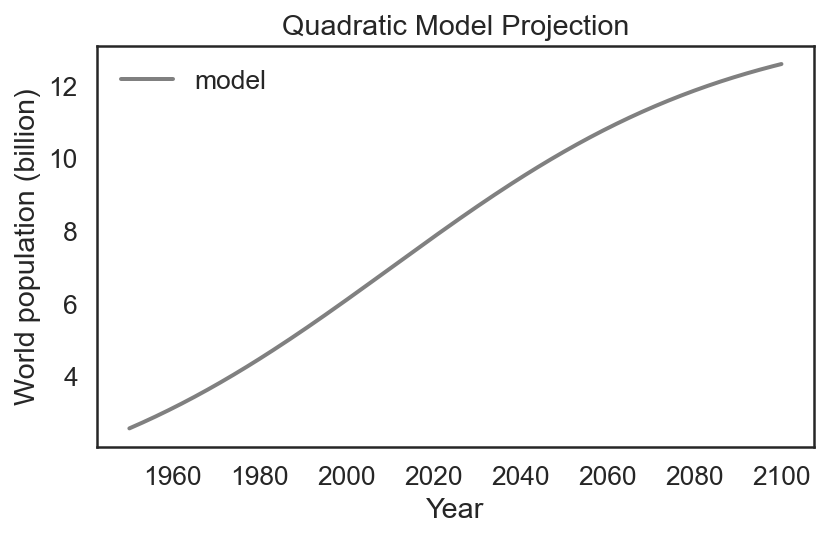

In [34]:
results.plot(color='gray', label='model')
modsim.decorate(
    xlabel='Year', 
    ylabel='World population (billion)',
    title='Quadratic Model Projection')

In [37]:
table3 = tables[3]
table3.columns = ['census', 'prb', 'un']
table3.head()

,census,prb,un
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


In [38]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census.dropna() / 1e9
    un_proj = table.un.dropna() / 1e9
    
    census_proj.plot(style=':', label='US Census')
    un_proj.plot(style='--', label='UN DESA')
    
    modsim.decorate(xlabel='Year', 
             ylabel='World population (billion)')

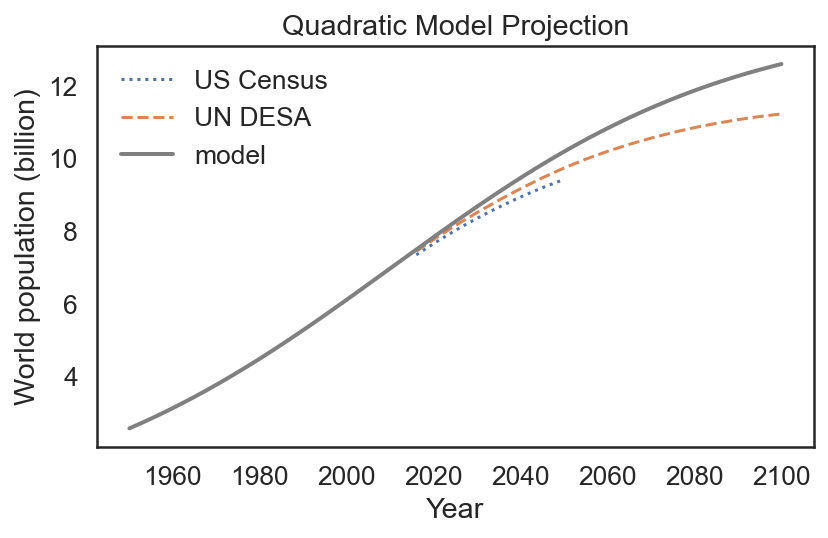

In [39]:
plot_projections(table3)
results.plot(color='gray', label='model')
modsim.decorate(title='Quadratic Model Projection')

### Exercise 1

The net growth rate of world population has been declining for several decades. That observation suggests one more way to generate more realistic projections, by extrapolating observed changes in growth rate.

To compute past growth rates, we’ll use a function called `diff`, which computes the difference between successive elements in a `Series`. For example, here are the changes from one year to the next in census:

In [43]:
diff = census.diff()
diff.head()

Year
1950         NaN
1951    0.037311
1952    0.041832
1953    0.045281
1954    0.048175
Name: census, dtype: float64

In [42]:
alpha = census.diff() / census # estimate of the growth rate during each year
alpha.head()

Year
1950         NaN
1951    0.014378
1952    0.015865
1953    0.016883
1954    0.017645
Name: census, dtype: float64

In [44]:
def plot_alpha():
    alpha_census = census.diff() / census
    alpha_census.plot(style='.', label='US Census')

    alpha_un = un.diff() / un
    alpha_un.plot(style='.', label='UN DESA')

    modsim.decorate(xlabel='Year', label='Net growth rate')

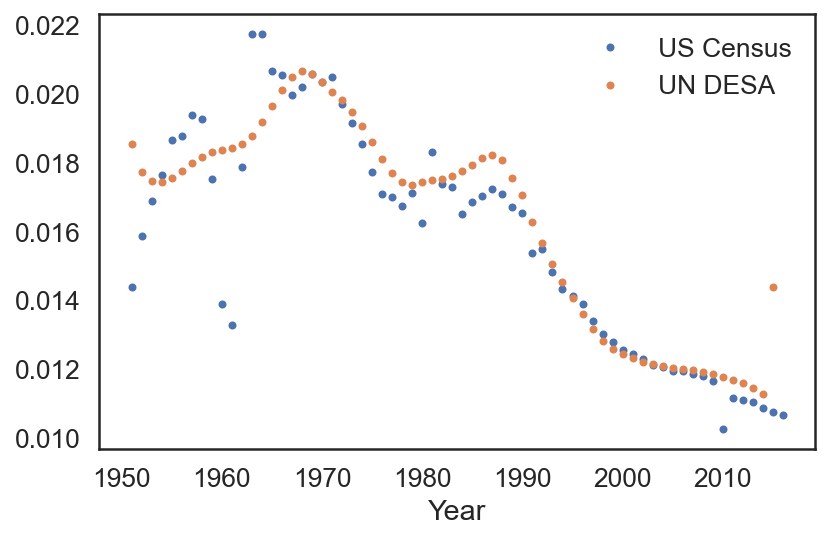

In [45]:
plot_alpha()

In [46]:
def alpha_func(t):
    intercept = 0.02
    slope = -0.00021
    return intercept + slope * (t - 1970)

In [47]:
t_array = numpy.linspace(1960, 2020, 5)
alpha_array = alpha_func(t_array)

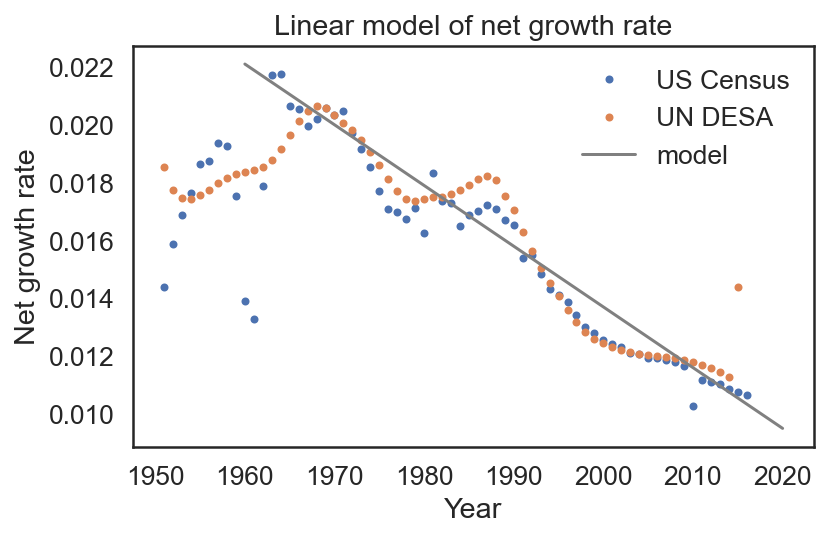

In [48]:
plot_alpha()
pyplot.plot(t_array, alpha_array, label='model', color='gray')

modsim.decorate(ylabel='Net growth rate',
         title='Linear model of net growth rate')

In [51]:
def alpha_func_2(t):
    intercept = 0.02
    slope = -0.00015
    return intercept + slope * (t - 1960)

In [64]:
def growth_func_quad_time(t, pop, system):
    return system.alpha_func(t) * pop

In [67]:
system1 = modsim.System(
    t_0 = 1960,
    p_0 = census[1960],
    t_end = 2100,
    alpha_func=alpha_func,
)

In [68]:
results = run_simulation(system1, growth_func_quad_time)

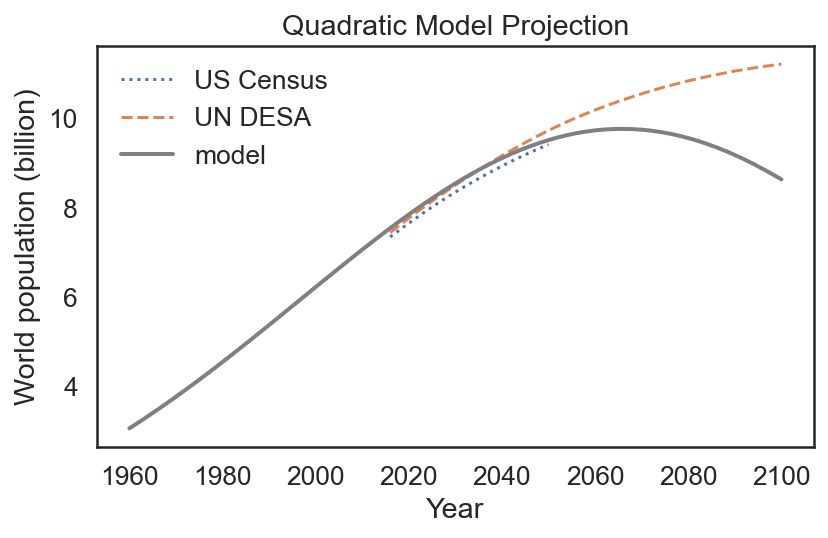

In [69]:
plot_projections(table3)
results.plot(color='gray', label='model')
modsim.decorate(title='Quadratic Model Projection')

In [70]:
# By extrapolating the observed decline in growth rate,
# we generate projections that are similar to the
# professionals' until about 2050.

# After that, our model predicts that world population 
# will peak around 2065 at about 9.8 billion, and then 
# start to decline.

results.idxmax(), results.max()


(2066, 9.75910331482456)